The purpose of this notebook is to practice modeling time series.

The data I am going to use is from Google Trends, showing the popularity of the search term "lululemon" since 2004.

![Lululemon store front](images/lulu_storefront.png)

The raw data (to which we don't have access) is the number of searches for "lululemon" per month.

This raw data is scaled by a factor of the largest number of searches for lululemon in a single month to obtain our data (**so a time series value of 100 indicates that, the largest number of searches ever conducted for "lululemon" in a single month occurred during that month.**)

Let's load the data and take a look at it.

In [6]:
# import pandas for data manipulation
import pandas as pd

# read data; skip header row
raw = pd.read_csv('data/lululemon_since_2004.csv', skiprows=1)

In [9]:
# change 'Month' to datetime format
raw['Month'] = pd.to_datetime(raw['Month'], format='%Y-%m')

# set the 'Month' to be the index
raw = raw.set_index('Month')

In the process of making the index a datetime object, I noticed that the column name for the values is weird. Let's make it "lululemon."

In [14]:
raw.columns = ['lululemon']

Months with low search counts are listed as '<1', which could be an issue for modeling. How many of these do we have?

In [18]:
raw.loc[raw.lululemon == '<1']

,lululemon
Month,
2004-01-01,<1
2004-02-01,<1
2004-04-01,<1
2004-09-01,<1
2004-10-01,<1
2004-12-01,<1
2005-01-01,<1
2005-02-01,<1
2005-03-01,<1


It looks like half of the months in 2004 and all of the months in 2005 had a small number of searches. When was lululemon founded? What did their expansion look like?

----

It appears that Lululemon was officially founded in 1998, went public in 2007 and started selling clothes online in 2009.

What if we use data from the year before lululemon went public, going forward? This will also allow us to convert the values in our series to type integer, since we will avoid the '<1' values completely.

In [21]:
data = raw['2006-01-01':].astype(int)

data.head()

,lululemon
Month,
2006-01-01,1
2006-02-01,1
2006-03-01,1
2006-04-01,1
2006-05-01,1


Now we're ready to plot our time series and get our first glimpse of any larger patterns in the data.

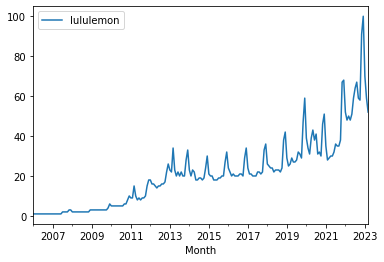

In [24]:
data.plot();

Excellent! We have an upward trend - possibly exponential - and some seasonality as well.

Let's work on stationarizing our data so that we can fit an ARIMA model to it and try to predict lululemon searches in the latter part of 2023.

#### Stationarizing the Series

First, we can confirm that our series is NOT stationary as-is with an augmented Dickey Fuller test.

In [26]:
from statsmodels.tsa.stattools import adfuller

# let's say our alpha value is 0.05, corresponding to 95% confidence
adfuller(data)[1]

0.9715262084982754

Our p-value is significantly larger than our preset alpha. This means that we fail to reject the null hypothesis (which is that our data is not stationary.)

To put it simply, our test confirms what we can visually see in the graph of the series; our series is NOT stationary.

What is the effect of differencing the series?

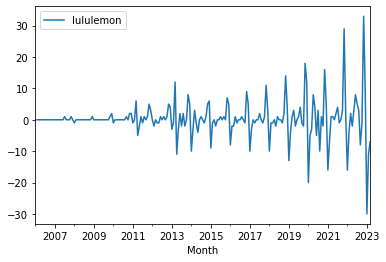

In [27]:
data.diff().plot();

Taking the first difference removes the upward linear trend from the data. The mean is now constant.

Next, we need to address the seasonality of the data and the increasing variance.

To deal with the increasing variance, let's try taking the logarithm. Now I realize that this should have been my first step. 😊 (Note: one reason for this, is that I can't take the logarithm of a negative number, and differencing typically introduces negative numbers.)

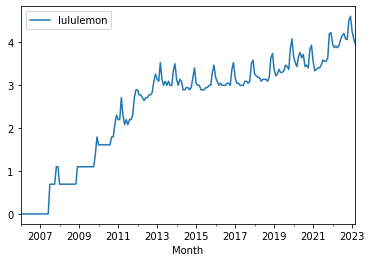

In [28]:
# import numpy for logarithm
import numpy as np

# plot log of scaled search counts
np.log(data).plot();

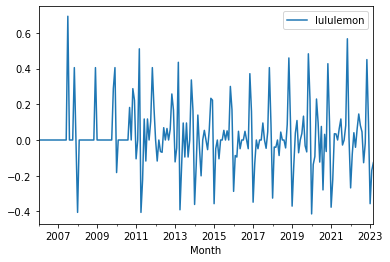

In [29]:
# now take the first difference
(np.log(data)).diff().plot();

Our data now has fairly constant variance and mean.

However, we still see some seasonality.

Let's see if we can dig into the data and figure out how many periods are required to repeat the seasonality trend.

2015 looks like a good year to inspect to confirm the seasonality pattern.

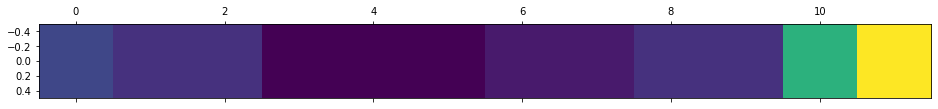

In [37]:
# import matplotlib module for heatmap
import matplotlib.pyplot as plt

# plot heatmap for 2015 data
plt.matshow(data['2015-01-01':'2015-12-31'].T);

In [39]:
# see actual numbers as well
data['2015-01-01':'2015-12-31'].T

Month,2015-01-01,2015-02-01,2015-03-01,2015-04-01,2015-05-01,2015-06-01,2015-07-01,2015-08-01,2015-09-01,2015-10-01,2015-11-01,2015-12-01
lululemon,21,20,20,18,18,18,19,19,20,20,27,32


So there seems to be a spike in lululemon searches in the last couple of months of the year (possibly corresponding to holiday gift-giving?)

Search popularity is pretty steady the rest of the year.

Let's try differencing over 12 time periods (months) to see if we can remove the seasonality.

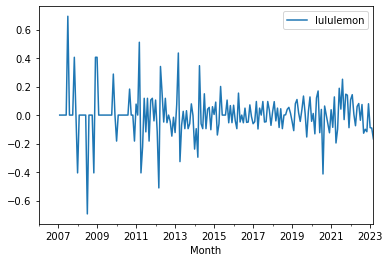

In [42]:
np.log(data).diff().diff(12).plot();

It seems that the same pattern didn't hold from 2007 to 2013 (we saw this pretty clearly above when plotting the logarithm of the original data, which appeared to be almost piecewise linear), but taking the 12th order difference did help to remove the seasonality from 2015 onward.

Let's repeat our augmented Dickey Fuller test to see if we have made this series stationary *enough* for modeling purposes.

In [45]:
# set alpha = 0.05
adfuller(np.log(data).diff().diff(12).dropna())[1]

4.227259072740585e-09

Our p-value is now tiny! Definitely smaller than 0.05.

We can now safely reject the null hypothesis that our series is stationary.

Let's assign this stationarized series to a variable.

In [46]:
series = np.log(data).diff().diff(12).dropna()

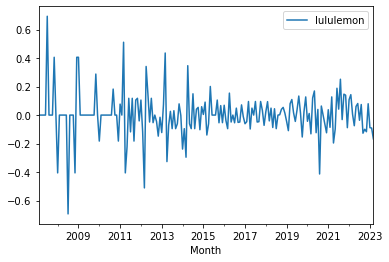

In [48]:
series.plot();

Now let's import everything we need to build an ARIMA model for the data.

#### Modeling (ARIMA)

First, let's import some functions for plotting auto-correlation and partial auto-correlation to help us determine the order of $p$ and $q$ for our model.

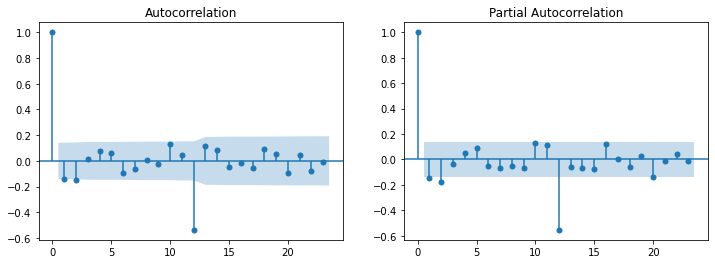

In [81]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

# plot acf and pacf side by side
fig, ax = plt.subplots(ncols=2, figsize=(12, 4))
plot_acf(series, ax=ax[0])
plot_pacf(series, ax=ax[1]);

It appears that both $p$ and $q$ should be set to 1.

Let's be sure to train-test split the data. I'm going to reserve data from 2020, 2021 and 2022 to be our "test" data and use the rest as training data.

In [77]:
train = series[:'2019-12-31']
test = series['2020-01-01':]

Now let's fit an ARIMA model with $p=1$ and $q=1$.

In [79]:
from statsmodels.tsa.arima.model import ARIMA
# fit model to training data, order is (p, d, q)
model = ARIMA(train, order=(1,0,1), freq='MS')

results = model.fit()

In [80]:
# view results
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:              lululemon   No. Observations:                  155
Model:                 ARIMA(1, 0, 1)   Log Likelihood                  68.017
Date:                Mon, 06 Mar 2023   AIC                           -128.033
Time:                        16:15:29   BIC                           -115.860
Sample:                    02-01-2007   HQIC                          -123.089
                         - 12-01-2019                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.0010      0.004     -0.241      0.810      -0.009       0.007
ar.L1          0.7641      0.078      9.813      0.000       0.611       0.917
ma.L1         -0.9433      0.056    -16.893      0.000      -1.053      -0.834
sigma2         0.0243      0.002     15.732      0.000       0.021       0.027
===================================================================================
Ljung-Box (L1) (Q):                   0.17   Jarque-Bera (JB):               188.39
Prob(Q):                              0.68   Prob(JB):                         0.00
Heteroskedasticity (H):               0.11   Skew:                             0.11
Prob(H) (two-sided):                  0.00   Kurtosis:                         8.40
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

The coefficients are statistically significant except for the constant. It's not immediately clear why this would be so, or what this means for our model's predictive accuracy. Let's leave it alone for now, and evaluate our model using a formal metric.

#### Model Evaluation

Let's compare our first ARIMA model to a "naive" model, then consider adjusting the orders to see if we can make any improvements (it's possible that I misread the acf / pacf plots.)

A naive model is one which predicts the value from the last time period for the current time period. (I would guess that this model performs pretty well because the search results don't vary widely from month to month, except for maybe the last and first months of the year when there is the seasonal spike in the data. Of course, we tried to remove this seasonality, so this may not be an issue.)

In [86]:
# import MSE metric
from sklearn.metrics import mean_squared_error

# use naive model, shifted one period forward, as baseline (drop null value for 1st month)
baseline = train.shift().dropna()

# calculate RMSE
np.sqrt(mean_squared_error(train[1:], baseline))

0.2454692802669959

The root mean squared error is pretty low for our baseline model. Did we beat it with our $p=q=1$ ARIMA model?

In [90]:
np.sqrt(results.mse)

0.1563036953463951

The RMSE is lower for our ARIMA model.

#### SARIMA Model

Let's try building a SARIMA model with the original data. I have a suspicion that the model can take care of differencing to remove trends and seasonality without me doing that first (although it is still a good exercise to understand our data.)

First, let's inspect the autocorrelation and partial autocorrelation plots for the original data.

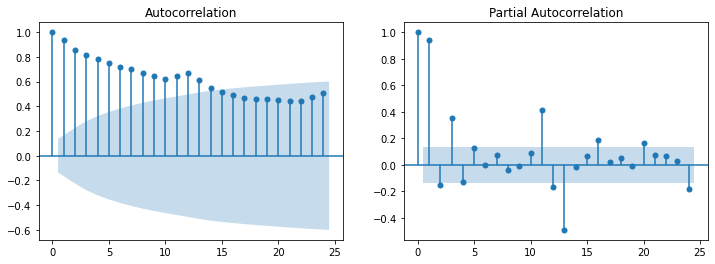

In [91]:
# plot acf and pacf side by side
fig, ax = plt.subplots(ncols=2, figsize=(12, 4))
plot_acf(data, ax=ax[0])
plot_pacf(data, ax=ax[1]);

These plots suggest that we need an AR model with $p=2$.

What if we plot the above for the **log** of the original data?

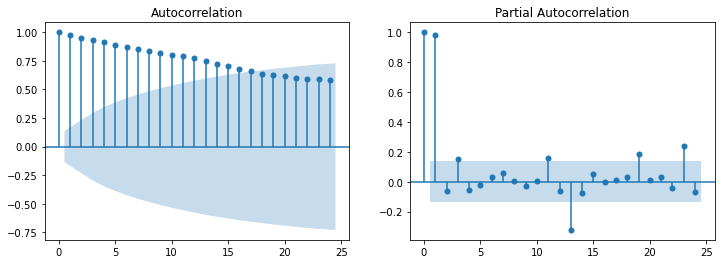

In [92]:
# plot acf and pacf side by side
fig, ax = plt.subplots(ncols=2, figsize=(12, 4))
plot_acf(np.log(data), ax=ax[0])
plot_pacf(np.log(data), ax=ax[1]);

There is very little difference, though everything seems a bit smoother. Let's use the log of the original data for our models going forward.

We'll do a train-test split with the log of the original data.

In [93]:
# train test split
train = np.log(data[:'2019-12-31'])
test = np.log(data['2020-01-01':])

I suspect seasonality every 12 months, so let's start with a seasonality of 12. (The degrees $p$ and $q$ we already determined from the acf and pacf plots above.) For $d$, I am going to use 1, because taking 1 difference seemed to be sufficient to visually remove the upward linear trend. Although, it might be worth trying higher order differences, particularly to deal with the seemingly different linear trends before and after 2013. (Treating the trend like an exponential one might help.)

In [94]:
sarima = ARIMA(train, seasonal_order=(2,1,0,12), freq='MS')
results=sarima.fit()

/Users/user/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'


In [95]:
# RMSE
np.sqrt(results.mse)

0.313232308340715

The root mean squared error is much worse. Let's try iterating over several types of models.

In [99]:
ps = [1, 2]
ds = [0, 1, 2]
qs = [0, 1, 2]
ss = [12, 14]

orders = []
rmses = []

for p in ps:
    for d in ds:
        for q in qs:
            for s in ss:
                orders.append((p, d, q, s))
                
for seasonal_order in orders:
    model = ARIMA(train, seasonal_order=seasonal_order)
    rmses.append(np.sqrt(model.fit().mse))


print(f'Best RMSE: {min(rmses)}')
print(f'Best model: {orders[np.argmin(rmses)]}')

Best RMSE: 0.3114303099448147
Best model: (1, 1, 2, 12)


Our best RMSE can't compete with the one we got with our detrended data and an ARIMA model with $p=q=1$.

Let's test our best ARIMA model on our test set, then move on to forecasting future search popularity.

In [110]:
# reset train and test data to detrended series
train = series[:'2019-12-31']
test = series['2020-01-01':]

# instantiate & fit ARIMA model with p=q=1
model = ARIMA(train, order=(1,0,1), freq='MS').fit()

# forecast up to 03-01 (39 months)
y_test_preds = model.forecast(39)

# check RMSE
np.sqrt(mean_squared_error(test, y_test_preds))

/Users/user/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'


0.12779655316565688

This is similar to (but technically even better than!) our model's performance on the training set. Perhaps because our model picked up on the trend from 2013 onward, though that may have hurt its performance on the earlier part of the training set?

Let's compare to the naive model's performance on the test set.

In [111]:
baseline = test.shift().dropna()

# calculate RMSE
np.sqrt(mean_squared_error(test[1:], baseline))

0.19067860955188012

We've beaten the baseline model on the test set. 😮‍💨 Let's move on to forecasting (i.e. predicting the future) now.

#### Forecasting (Predicting the Future)

How popular (in terms of Google searches for "lululemon") will Lululemon be in the latter half of 2023? or in early 2024?

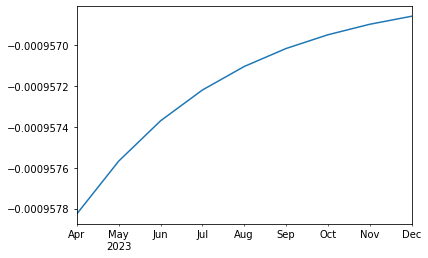

In [114]:
# forecast into the future!

model.forecast(39+9)['2023-03-31':].plot();

Of course, now we have to undo all of the changes we made to the data. This is how we formed the series we used for modeling from our original data:

`series = np.log(data).diff().diff(12).dropna()`

So we need to un-difference by 12, then undo the first order difference, then exponentiate the result.

To "un-difference" the data, we need a starting value. E.g. the value for 2023-03-01 could be used. (Or, for greater accuracy, we should use the value for February, since that month has been fully completed at the time of this writing.)

To "undo" the 12th difference, I need to *add* the logarithm of the first differnece of the actual time series value from 12 time periods ago. So let's get a shifted version of our time series to add to our forecast.

In [146]:
# predict test set, then extend 11 mos into future
# only 11 mos, because Mar is included in test, but Mar is not finished yet
forecast = model.forecast(39+11)['2023-02-01':]

In [149]:
# shift values from 12 months before forecast, 12 mos forward
seasonal_shift = pd.Series([i[0] for i in data['2022-01-31':'2023-02-28'].values],
                           index=forecast.index)
# take log of time series values & first difference
seasonal_shift = np.log(seasonal_shift).diff().dropna()

Now, below we have the value of `np.log(data).diff()`. (The 12 month "seasonal" difference has been undone.)

In [151]:
(forecast + seasonal_shift).dropna()

2023-03-01    0.039864
2023-04-01   -0.041780
2023-05-01    0.059667
2023-06-01    0.144754
2023-07-01    0.080388
2023-08-01    0.044852
2023-09-01   -0.128112
2023-10-01   -0.018051
2023-11-01    0.449460
2023-12-01    0.093354
2024-01-01   -0.357632
2024-02-01   -0.171915
Freq: MS, dtype: float64

Next we will undo the first difference, then we will finally be ready to exponentiate.

To undo the first difference, we will start by adding the predicted value for 2023-03-01 (without the seasonal difference) to the log of the true time series value for the previous month.

In [172]:
np.log(data.loc['2023-02-01'].values[0])

4.07753744390572

Then this sum will be added to the next row in the forecast (without the seasonal difference.) And so on and so forth.

In [173]:
# name the step after "adding back in" seasonality
with_seasonal = (forecast + seasonal_shift).dropna()

# update the first term using original data
with_seasonal[0] += np.log(data.loc['2023-02-01'].values[0])

# update additional terms using previous term
for i in range(1, len(with_seasonal)):
    with_seasonal[i] += with_seasonal[i-1]

In [175]:
# exponentiate to "undo" logarithm
true_forecast = np.exp(with_seasonal)

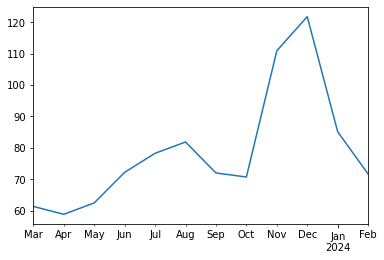

In [176]:
# plot to get a quick idea of feasibility
true_forecast.plot();

The plot certainly doesn't look totally out of place. Let's plot our actual data with the forecast values on the same graph to see if anything *looks* majorly out of place.

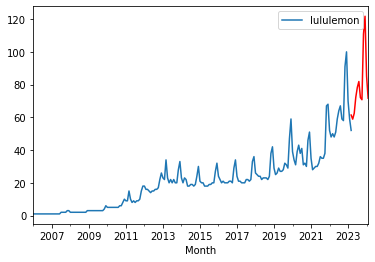

In [177]:
fig, ax = plt.subplots()
data.plot(ax=ax)
true_forecast.plot(ax=ax, c='r');

Interesting. Despite not training our model on the data from 2020 onward, it has clearly picked up on the steep upward linear trend at the "end" of the graph.

In the peak months of 2023, google search interest in "lululemon" will grow by 20% from peak interest last year (2022.)

#### Limitations

Does this model account for an inevidible "leveling off" of upward growth?

#### Next Steps

That was a lot of work for something that doesn't persist! If this graph seems valuable to the Lululemon execs, then I can work on cleaning up the code to make it "deployable" and having it automatically update with new data and feed into a dashboard.